# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.1 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds['lwe_thickness']
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [28]:
## Full catalog

# Convert catalog to GeoDataFrame
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  # Handle the earthquakes by "mascon"

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf_full.sindex


## ETAS declustered catalog

# Convert catalog to GeoDataFrame
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")  # Handle the earthquakes by "mascon"

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf_etas.sindex

In [42]:
def calc_cp_by_mascon(catalog, geometry, catalog_gdf, L_override):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5 degree radius spherical cap around each one.
    If L_override is provided, it replaces the calculated L.
    """
    cp = []
    
#     # Convert catalog to GeoDataFrame
#     geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
#     catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")  # Handle the earthquakes by "mascon"

#     # Create spatial index for catalog_gdf to optimize spatial joins
#     catalog_gdf.sindex
    
    # Iterate through each mascon center
    # for i in tqdm(range(len(mascon_id)), miniters=500):
    for i in range(len(mascon_id)):
        # Create a Point for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Spatial join to find earthquakes within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # Skip to the next iteration if no earthquakes are found within this cap
        if these_earthquakes.empty:
            continue

        # Retrieve load data for this mascon using the center coordinates
        these_loads = lwe_data.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Determine the value of L to use
        if L_override is not None:
            L = L_override  # Use provided L_override
        else:
            L = these_loads  # Use internally calculated L
            
        LgE = these_earthquakes.dmass # Load at the time of earthquake (in the spherical cap where the eq is located)
        L = these_loads # Load at all times in the spherical cap where eq occurred
        E = len(these_earthquakes) # Probability of an earthquake at a given time and location

        # Compute P(E|L)
        bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E
        cp.append(this_cp)

    # Average conditional probabilities across all mascons
    cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return cp_averaged, bins

In [43]:
cp_averaged, bins = calc_cp_by_mascon(catalog, geometry_full, catalog_gdf_full, L_override=None)

## 2.2 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [44]:
etas_cp_averaged, bins = calc_cp_by_mascon(etas_declustered, geometry_etas, catalog_gdf_etas, L_override=None)

In [45]:
# '''
# Sanity Check!
# '''
# base = bbox_gdf.boundary.plot(color='red', linewidth=2)
# catalog_gdf.plot(ax=base, marker='o', color='blue', markersize=5, label='All Earthquakes')
# # these_earthquakes.plot(ax=base, marker='o', color='red', markersize=5, label='Selected Earthquakes')
# plt.xlim([-2,2])
# plt.ylim([-88,-92])
# plt.legend()
# plt.show()

## 2.3 Visualizing correlation for full & declustered catalog

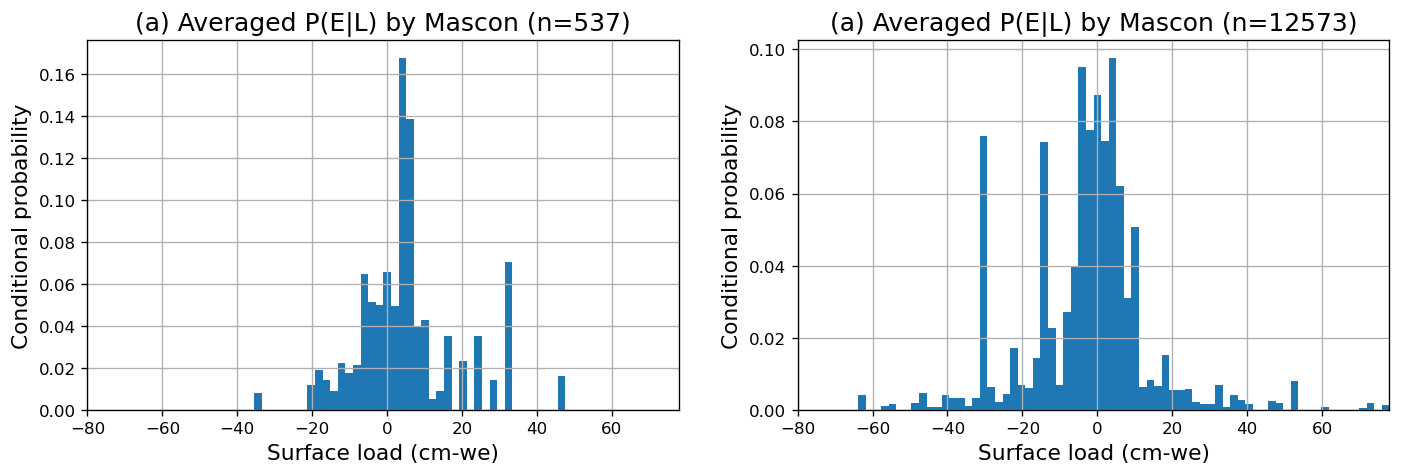

In [52]:
fig, axes = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13

### (a) P(E|L) by Mascon (ETAS)
wid_etas = np.mean(np.diff(bins))

axes[0].bar(bins[:-1], etas_cp_averaged / np.sum(etas_cp_averaged), 
       width=wid_etas, align='edge')

axes[0].set_xlim(bins[0], bins[-2])
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability', fontsize=fs)
axes[0].set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
axes[0].grid(True)

### (b) P(E|L) by Mascon (full catalog)
axes[1].bar(bins[:-1], cp_averaged / np.sum(cp_averaged), 
       width=wid_etas, align='edge')

axes[1].set_xlim(bins[0], bins[-2])
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[1].set_ylabel('Conditional probability', fontsize=fs)
axes[1].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
axes[1].grid(True)

## 3.1 Permutation testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [47]:
# Number of randomizations
N = 5

In [48]:
# Last run on Jan 31, 2025 -- time taken: ~9.5 hours

# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

cp_real_distribution = []

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    cp_averaged, bins = calc_cp_by_mascon(catalog, geometry_full, catalog_gdf_full, L_override=scrambled_data)
    cp_real_distribution.append(cp_averaged)  # Store as a list of arrays

# Convert to NumPy array for proper averaging
cp_real_distribution = np.array(cp_real_distribution)  # Shape: (N, num_bins)

# Compute final averaged probability distribution
cp_real_distribution_avg = np.mean(cp_real_distribution, axis=0)  # Shape: (num_bins,)

100%|████████████████████████████████████████████| 5/5 [12:54<00:00, 154.93s/it]


## 3.2  Repeating analysis for ETAS declustered catalog

In [49]:
# Last run on Jan 31, 2025 -- time taken: ~6 hours

# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

etas_cp_real_distribution = []

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    etas_cp_averaged, bins = calc_cp_by_mascon(etas_declustered, geometry_etas, catalog_gdf_etas, L_override=scrambled_data)
    etas_cp_real_distribution.append(etas_cp_averaged)  # Store as a list of arrays

# Convert to NumPy array for proper averaging
etas_cp_real_distribution = np.array(etas_cp_real_distribution)  # Shape: (N, num_bins)

# Compute final averaged probability distribution
etas_cp_real_distribution_avg = np.mean(etas_cp_real_distribution, axis=0)  # Shape: (num_bins,)

100%|█████████████████████████████████████████████| 5/5 [02:50<00:00, 34.20s/it]


## 4. Figures

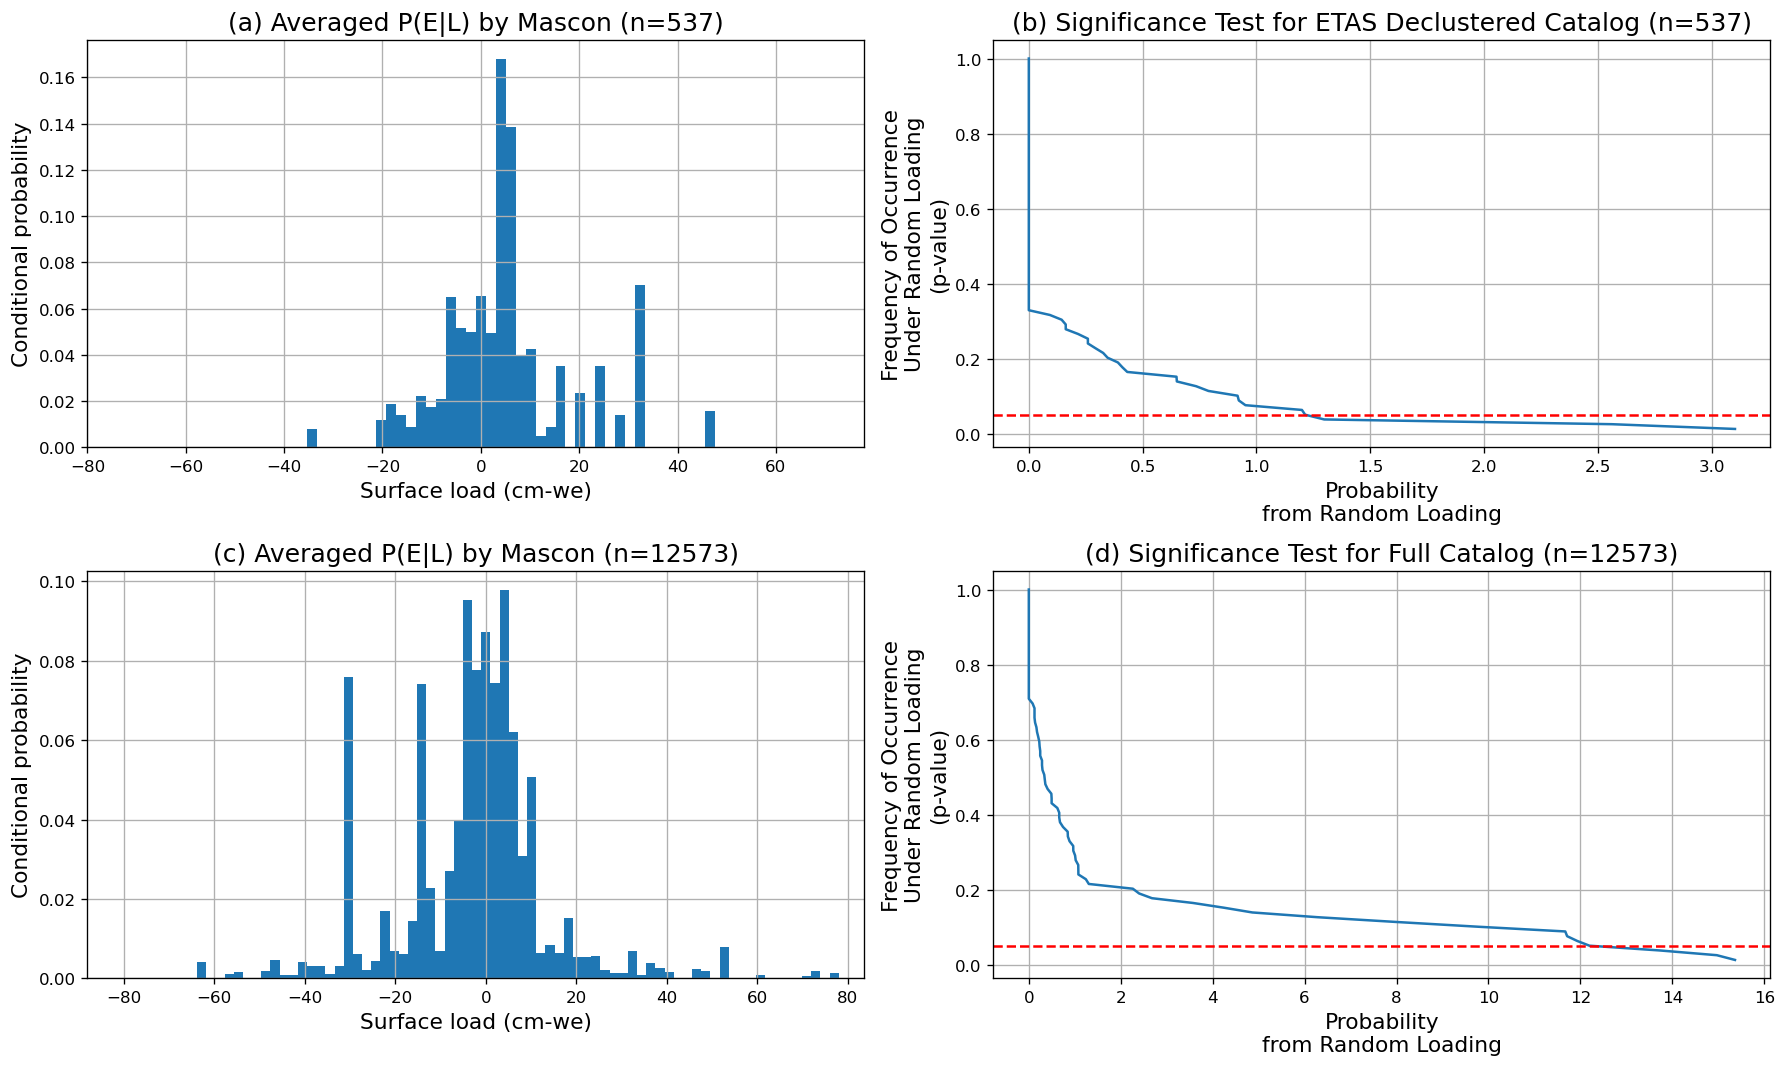

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9), dpi=120)
fs = 13

### (a) P(E|L) by Mascon (ETAS)
ax = axes[0, 0]  
wid_etas = np.mean(np.diff(bins))

# Use the corrected average instead of raw etas_cp_averaged
ax.bar(bins[:-1], etas_cp_real_distribution_avg / np.sum(etas_cp_real_distribution_avg), 
       width=wid_etas, align='edge')

ax.set_xlim(bins[0], bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax.grid(True)

### (b) Significance test for ETAS declustered catalog
ax1 = axes[0, 1]  
etas_sorted_data = np.sort(etas_cp_real_distribution_avg)  # Use final averaged version
ax1.plot(etas_sorted_data, 1 - np.arange(etas_sorted_data.size) / etas_sorted_data.size)

ax1.axhline(y=0.05, color='r', linestyle='--')
ax1.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax1.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax1.set_title('(b) Significance Test for ETAS Declustered Catalog (n=537)', fontsize=fs + 2)
ax1.grid(True)

### (c) P(E|L) by Mascon (Full Catalog)
ax3 = axes[1, 0]  
wid = np.mean(np.diff(bins))

# Use final averaged conditional probability
ax3.bar(bins[:-1], cp_real_distribution_avg / np.sum(cp_real_distribution_avg), 
       width=wid, align='edge')

xl = ax3.get_xlim()
ax3.set_xlim(xl[0], xl[1] - 4.4)
ax3.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax3.set_ylabel('Conditional probability', fontsize=fs)
ax3.set_title('(c) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax3.grid(True)

### (d) Significance test for full catalog
ax2 = axes[1, 1]  
sorted_data = np.sort(cp_real_distribution_avg)  # Use final averaged version
ax2.plot(sorted_data, 1 - np.arange(sorted_data.size) / sorted_data.size)

ax2.axhline(y=0.05, color='r', linestyle='--')
ax2.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax2.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax2.set_title('(d) Significance Test for Full Catalog (n=12573)', fontsize=fs + 2)
ax2.grid(True)

plt.tight_layout()
plt.show()